In [7]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
df = pd.read_excel("SCUT-FBP5500_v2/All_Ratings.xlsx")
df.head()

,Rater,Filename,Rating,original Rating
0,1,CF1.jpg,3,NaN
1,1,CF10.jpg,3,NaN
2,1,CF100.jpg,1,NaN
3,1,CF101.jpg,2,NaN
4,1,CF102.jpg,3,NaN


In [9]:
df = df.drop(columns="original Rating", axis=1)
df.head()

,Rater,Filename,Rating
0,1,CF1.jpg,3
1,1,CF10.jpg,3
2,1,CF100.jpg,1
3,1,CF101.jpg,2
4,1,CF102.jpg,3


In [10]:
df_y = df.groupby("Filename")["Rating"].mean().reset_index()
file_name = df_y[["Filename"]].to_numpy().flatten()
df_y = df_y["Rating"].to_numpy() / 5.0

In [11]:
def load_and_preprocess_image(img_path, target_size=(350, 350)):
    """
    이미지를 불러와 전처리합니다.
    img_path: 이미지 경로
    target_size: CNN 입력으로 사용할 이미지의 크기
    """
    path = "SCUT-FBP5500_v2/Images/"
    img = image.load_img(path+img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 모델에 입력하기 위해 차원을 확장
    return img_array / 255.0  # 이미지를 [0, 1] 범위로 정규화

def load_images(image_filenames, target_size=(350, 350)):
    images = [load_and_preprocess_image(img_path, target_size) for img_path in image_filenames]
    return np.vstack(images)  # 이미지 목록을 하나의 배열로 합치기

In [12]:
# 함수를 사용하여 이미지 데이터를 준비
df_x = load_images(file_name)

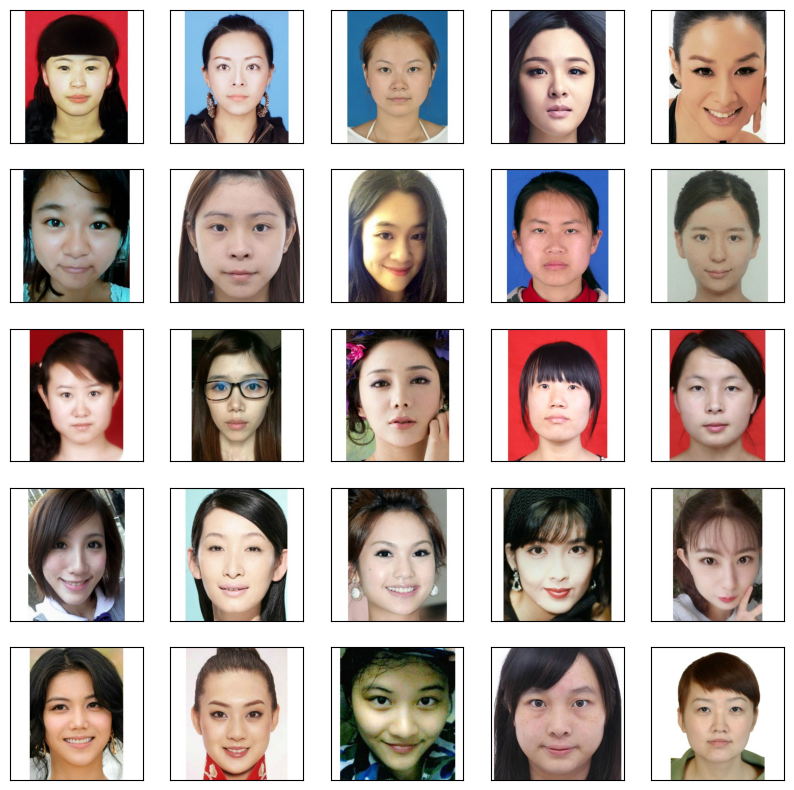

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(df_x[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
plt.show()

In [14]:
df_x.shape

(5500, 350, 350, 3)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=1234)
x_train, x_valid, y_train, y_valid  =train_test_split(x_train, y_train, test_size=0.25, random_state=1234)

In [16]:
print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(3300, 350, 350, 3) (1100, 350, 350, 3) (1100, 350, 350, 3)
(3300,) (1100,) (1100,)


In [17]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(350, 350, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='linear'))
model.summary()

2023-09-21 02:59:30.054633: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 02:59:32.648650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 02:59:32.651390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-21 02:59:32.750851: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 348, 348, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 174, 174, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 172, 172, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 170, 170, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 85, 85, 64)       0         
 2D)                                                    

In [18]:
model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_valid, y_valid))

Epoch 1/50


2023-09-21 02:59:48.128609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2023-09-21 02:59:54.160799: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-09-21 02:59:58.594016: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


104/104 [==============================] - 24s 67ms/step - loss: 249.8907 - accuracy: 0.0000e+00 - val_loss: 0.0374 - val_accuracy: 0.0000e+00
Epoch 2/50
104/104 [==============================] - 5s 49ms/step - loss: 0.0180 - accuracy: 0.0000e+00 - val_loss: 0.0636 - val_accuracy: 0.0000e+00
Epoch 3/50
104/104 [==============================] - 5s 50ms/step - loss: 0.0204 - accuracy: 0.0000e+00 - val_loss: 0.0192 - val_accuracy: 0.0000e+00
Epoch 4/50
104/104 [==============================] - 5s 50ms/step - loss: 0.0185 - accuracy: 0.0000e+00 - val_loss: 0.2691 - val_accuracy: 0.0000e+00
Epoch 5/50
104/104 [==============================] - 5s 49ms/step - loss: 0.0162 - accuracy: 0.0000e+00 - val_loss: 0.4597 - val_accuracy: 0.0000e+00
Epoch 6/50
104/104 [==============================] - 5s 50ms/step - loss: 0.0154 - accuracy: 0.0000e+00 - val_loss: 0.4964 - val_accuracy: 0.0000e+00
Epoch 7/50
104/104 [==============================] - 5s 50ms/step - loss: 0.0154 - accuracy: 0.0000e+

In [19]:
predict = model.predict(x_test)

In [20]:
y_pred = predict.flatten()*5
y_true = y_test * 5

In [21]:
y_true

array([2.86666667, 2.63333333, 2.3       , ..., 2.43333333, 1.93333333,
       3.05      ])

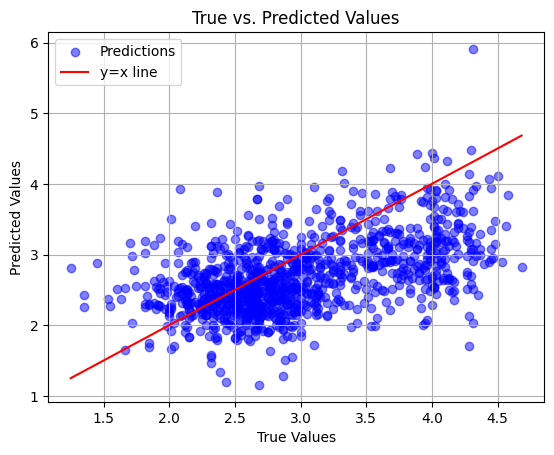

In [22]:
plt.scatter(y_true, y_pred, color='blue', alpha=0.5, label='Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', label='y=x line')

plt.title('True vs. Predicted Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

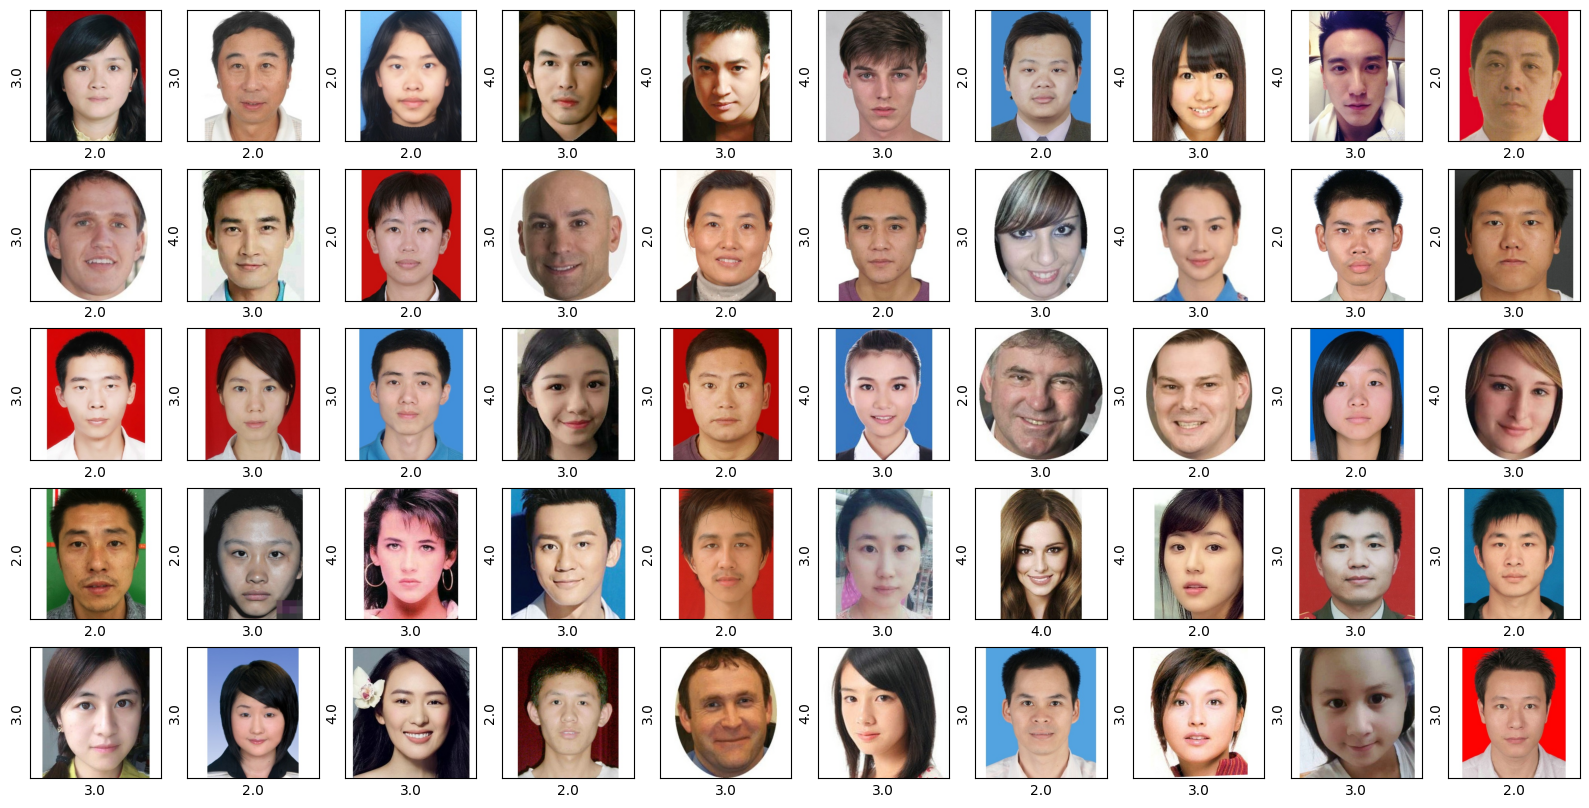

In [23]:
plt.figure(figsize=(20,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i])
    plt.ylabel(y_true[i].round())
    plt.xlabel(y_pred[i].round())
plt.show()

In [24]:
y_pred = y_pred.round()
y_true = y_true.round()

In [25]:
np.mean(y_pred==y_true)

0.4445454545454545